# Random Forest Classification

### Notebook Introduction: Transitioning to Random Forest for Financial Time Series Analysis

In the previous notebook, we explored the performance of **Logistic Regression** in predicting future price movements for Bitcoin (BTC). While the results showed incremental improvements with longer lookahead periods, we observed that logistic regression struggled with the inherent non-linear dynamics and feature interactions within the data. Key limitations included:

- Over-sensitivity to certain trend-based features (e.g., RSI, moving averages).
- Bias towards predicting upward price movements (`1`) at the expense of downward movements (`0`).
- Poor handling of non-linear patterns and class imbalances.

These challenges prompted us to explore **Random Forest**, a more advanced model capable of capturing complex relationships and interactions in the data.

---

### Goals of This Notebook

This notebook focuses on implementing a **Random Forest Classifier** to address the limitations of logistic regression. Here's what we aim to accomplish:

1. **Feature Engineering**: Continue leveraging features such as moving averages, RSI, Bollinger Bands, and volume-based metrics, while ensuring they're scaled and preprocessed effectively.
2. **Model Training and Evaluation**: Train the Random Forest classifier, evaluate its performance, and compare it to our logistic regression baseline.
3. **Visual Insights**: Use precision-recall curves, confusion matrices, and feature importance plots to interpret the model's predictions and assess its strengths and weaknesses.
4. **Analyze Lookahead Periods**: Test the model's performance across different lookahead periods to observe how prediction horizons affect accuracy and recall for both classes.

---

### Why Random Forest?

Random Forest is well-suited to financial time series analysis due to its:

- **Ability to handle non-linear relationships**: BTC prices exhibit volatile, non-linear behaviors that Random Forest can capture through its ensemble of decision trees.
- **Robustness to noise**: By averaging predictions from multiple trees, Random Forest minimizes overfitting to noisy features or outliers.
- **Flexibility in feature interactions**: Features like Bollinger Bands and RSI may interact in complex ways that Random Forest naturally accounts for.
- **Balanced class handling**: With proper hyperparameter tuning, Random Forest can better address the imbalance in predicting price decreases (`0`).

---

As we step into the Random Forest implementation, I'll guide you through the code and analysis in a structured way. Let’s get started by preparing the dataset for training and visualization.

### Step 1: Import Libraries
We begin by importing the required libraries for data processing, feature engineering, model training, and evaluation. The key libraries include:
- `pandas` and `numpy` for data manipulation.
- `sklearn` for model building and evaluation.
- `matplotlib` and `seaborn` for visualizations.


In [74]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_recall_curve, 
    precision_score, recall_score, f1_score, 
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


## Step 2: Load and Preprocess the Dataset

The dataset contains BTC price and volume information. We preprocess the data by:
1. **Sorting by date**: Ensures a chronological order for time-series analysis.
2. **Feature Engineering**: Adds technical indicators such as:
   - Moving Averages (7, 14, 30-day).
   - Relative Strength Index (RSI) for momentum analysis.
   - Bollinger Bands for volatility insights.
   - Volume-based indicators.
3. **Data Cleaning**: Removes rows with missing values caused by rolling calculations.

These features help the model understand trends, volatility, and momentum in the BTC market.


In [75]:
def load_and_preprocess(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.lower()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    # Feature engineering
    df['ma_7day'] = df['close'].rolling(7).mean()
    df['ma_14day'] = df['close'].rolling(14).mean()
    df['ma_30day'] = df['close'].rolling(30).mean()

    df['price_change'] = df['close'].diff()
    df['gain'] = df['price_change'].clip(lower=0)
    df['loss'] = -1 * df['price_change'].clip(upper=0)
    avg_gain = df['gain'].rolling(14).mean()
    avg_loss = df['loss'].rolling(14).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))

    df['bb_middle'] = df['close'].rolling(20).mean()
    df['bb_std'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_middle'] + (2 * df['bb_std'])
    df['bb_lower'] = df['bb_middle'] - (2 * df['bb_std'])

    df['volume_ma_7day'] = df['volume'].rolling(7).mean()

    return df.dropna()

# Load dataset
PROJECT_ROOT = Path().resolve()
csv_path = PROJECT_ROOT / "../data/raw/btc_usd.csv"
df = load_and_preprocess(csv_path)
print(df.head())


                        date        open        high         low       close  \
29 2014-10-16 00:00:00+00:00  394.518005  398.807007  373.070007  382.556000   
30 2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
31 2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
32 2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
33 2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   

      volume  dividends  stock splits     ma_7day    ma_14day    ma_30day  \
29  26990000        0.0           0.0  381.574720  361.724505  384.112801   
30  13600700        0.0           0.0  384.745575  363.456362  381.660267   
31  11416800        0.0           0.0  388.908857  367.926076  380.560333   
32   5914570        0.0           0.0  390.479854  372.857217  380.385333   
33  16419000        0.0           0.0  389.398568  376.626216  379.516700   

    price_change      gain       loss        rsi   bb_mi

## Step 3: Train and Evaluate the Model

For each lookahead period, we:
1. **Define the Target**: Classify price movement as `1` if the future price increases and `0` otherwise.
2. **Split the Dataset**: Train-test split ensures the model is evaluated on unseen data.
3. **Feature Scaling**: Scales the features for better model performance.
4. **Model Training**: Trains a Random Forest Classifier with default hyperparameters.
5. **Model Evaluation**: Calculates metrics such as accuracy, precision, recall, F1 score, and confusion matrix.


In [76]:
def train_and_evaluate(df, lookahead_days, feature_columns):
    df[f'future_close_{lookahead_days}'] = df['close'].shift(-lookahead_days)
    df[f'target_{lookahead_days}'] = (df[f'future_close_{lookahead_days}'] > df['close']).astype(int)
    df_clean = df.dropna(subset=[f'future_close_{lookahead_days}'])

    X = df_clean[feature_columns]
    y = df_clean[f'target_{lookahead_days}']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
    model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_test_pred = model.predict(X_test_scaled)
    y_test_probs = model.predict_proba(X_test_scaled)[:, 1]

    metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1_score': f1_score(y_test, y_test_pred),
        'confusion_matrix': confusion_matrix(y_test, y_test_pred),
        'precision_recall_curve': precision_recall_curve(y_test, y_test_probs)
    }
    return model, metrics


## Step 4: Visualize Results

For each lookahead period:
1. **Confusion Matrix**: Provides insights into false positives, false negatives, and correct predictions.
2. **Precision-Recall Curve**: Highlights the trade-off between precision and recall, helping us understand model performance at different thresholds.


In [77]:
def visualize_results(metrics, lookahead_days):
    print(f"Results for {lookahead_days}-Day Lookahead")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({lookahead_days}-Day Lookahead)")
    plt.show()

    # Precision-recall curve
    precision, recall, _ = metrics['precision_recall_curve']
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({lookahead_days}-Day Lookahead)")
    plt.legend()
    plt.grid()
    plt.show()


## Define Feature Columns

In [78]:
feature_columns = [
    'open', 'high', 'low', 'volume',
    'ma_7day', 'ma_14day', 'ma_30day', 'rsi',
    'bb_upper', 'bb_lower', 'bb_middle', 'volume_ma_7day'
]

## Evaluate for 14-Day and 30-Day Lookahead Periods

We evaluate the Random Forest model for 14-day and 30-day lookahead periods to observe how the prediction horizon affects model performance.


Results for 14-Day Lookahead
Accuracy: 0.8148
Precision: 0.8133
Recall: 0.8696
F1 Score: 0.8405
Confusion Matrix:
[[362 124]
 [ 81 540]]


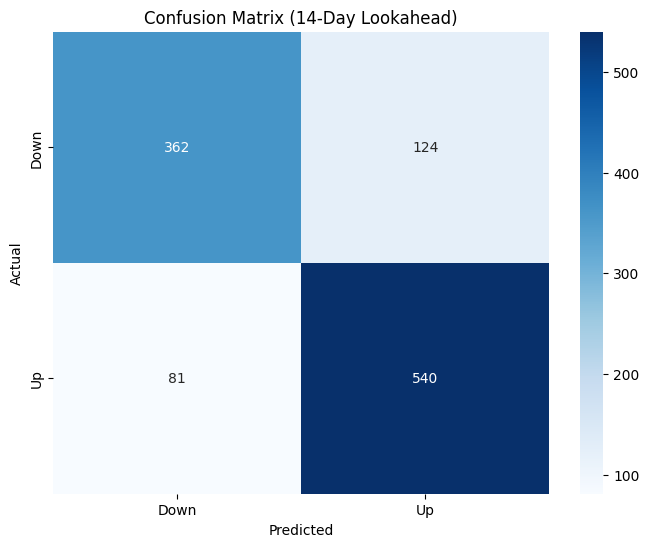

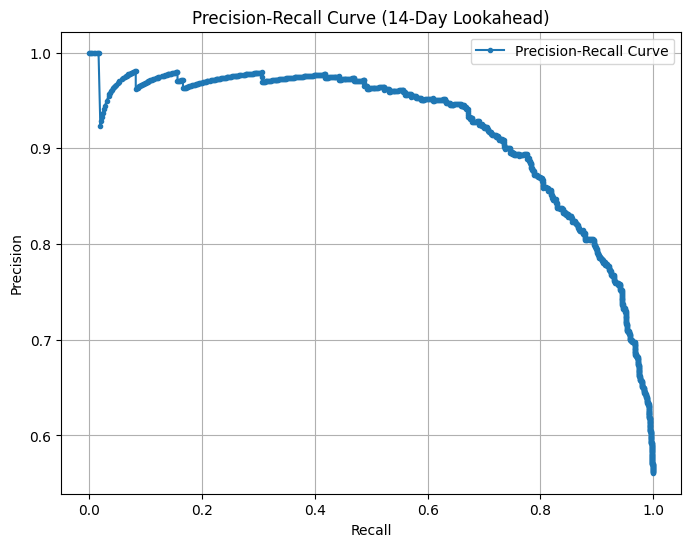

In [79]:
feature_columns = [
    'open', 'high', 'low', 'volume',
    'ma_7day', 'ma_14day', 'ma_30day', 'rsi',
    'bb_upper', 'bb_lower', 'bb_middle', 'volume_ma_7day'
]

model_14, metrics_14 = train_and_evaluate(df, 14, feature_columns)
visualize_results(metrics_14, 14)



Results for 7-Day Lookahead
Accuracy: 0.7376
Precision: 0.7283
Recall: 0.8428
F1 Score: 0.7814
Confusion Matrix:
[[298 194]
 [ 97 520]]


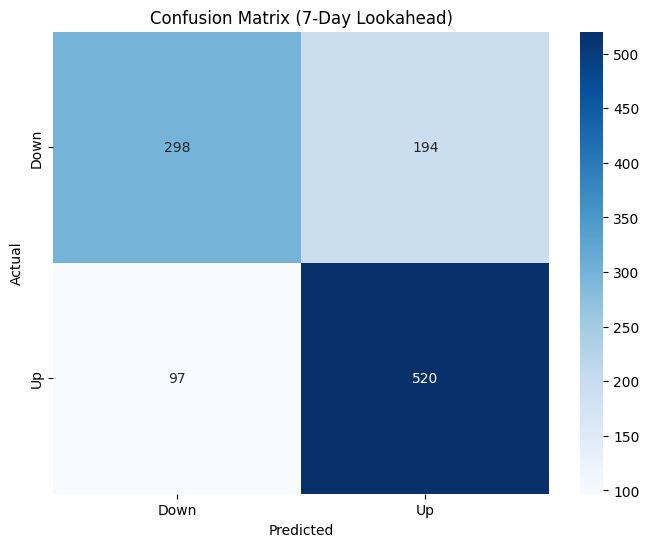

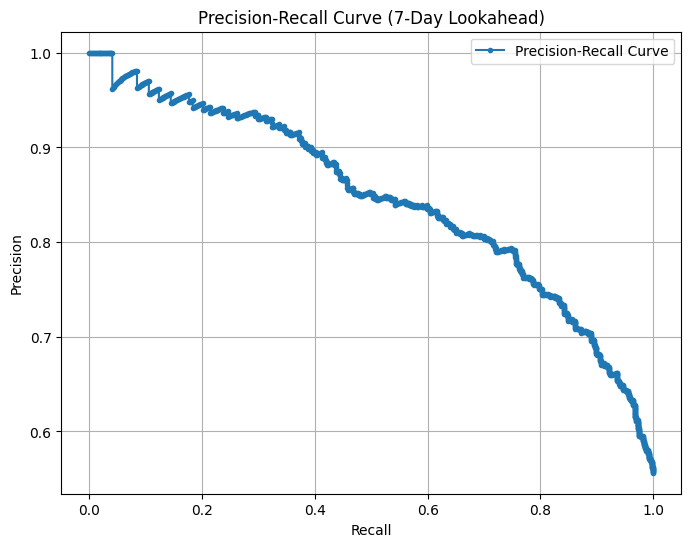

In [80]:
model_7, metrics_7 = train_and_evaluate(df, 7, feature_columns)
visualize_results(metrics_7, 7)


Results for 30-Day Lookahead
Accuracy: 0.8666
Precision: 0.8603
Recall: 0.9184
F1 Score: 0.8884
Confusion Matrix:
[[370  95]
 [ 52 585]]


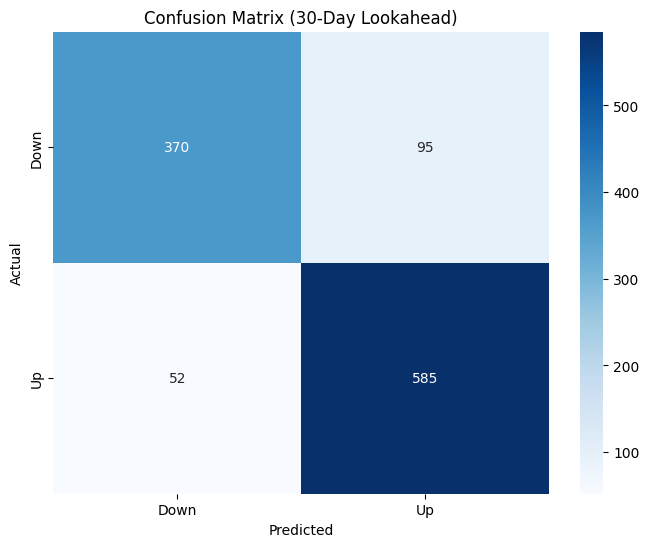

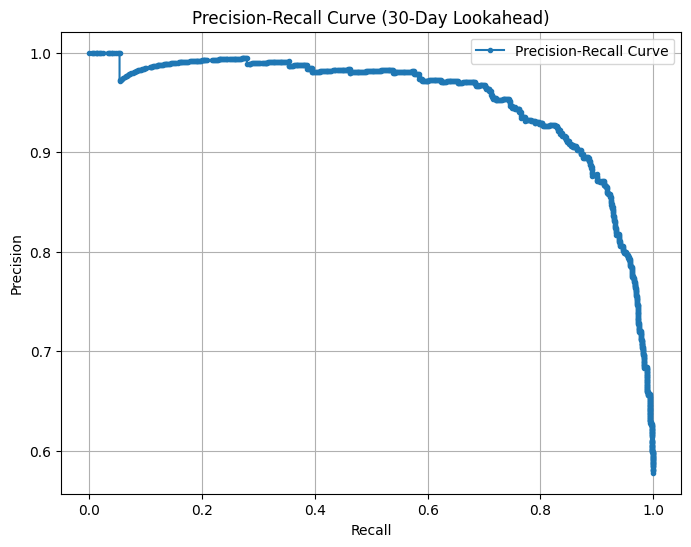

In [81]:
model_30, metrics_30 = train_and_evaluate(df, 30, feature_columns)
visualize_results(metrics_30, 30)


Results for 45-Day Lookahead
Accuracy: 0.8898
Precision: 0.8843
Recall: 0.9350
F1 Score: 0.9090
Confusion Matrix:
[[373  79]
 [ 42 604]]


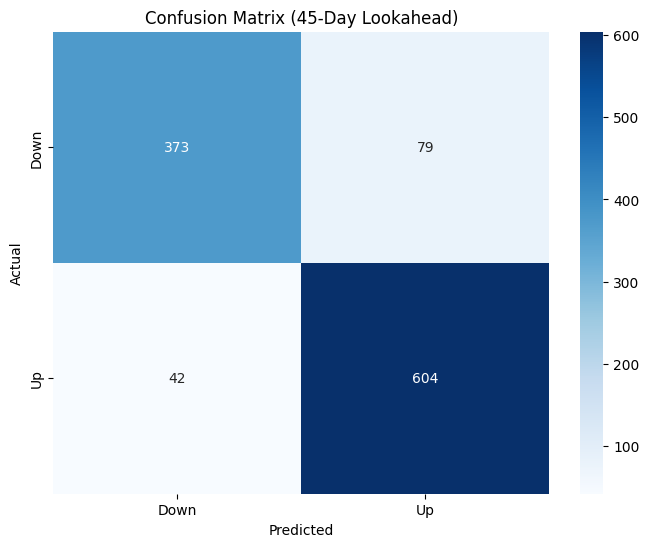

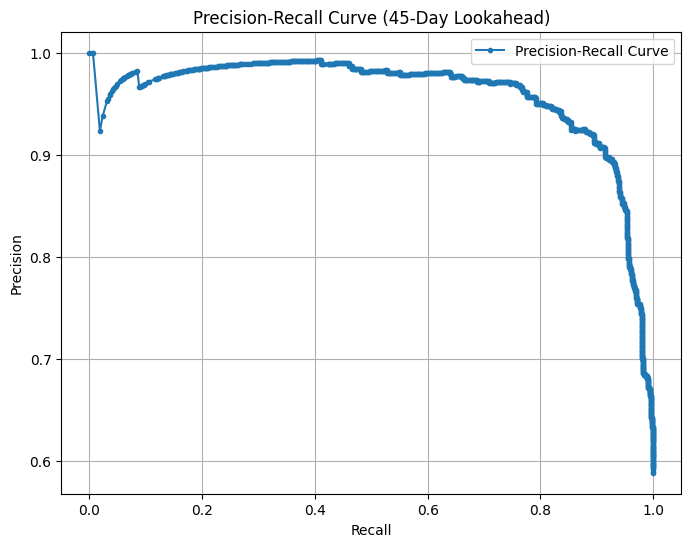

In [82]:
model_45, metrics_45 = train_and_evaluate(df, 45, feature_columns)
visualize_results(metrics_45, 45)


Results for 90-Day Lookahead
Accuracy: 0.9170
Precision: 0.9217
Recall: 0.9487
F1 Score: 0.9350
Confusion Matrix:
[[347  55]
 [ 35 647]]


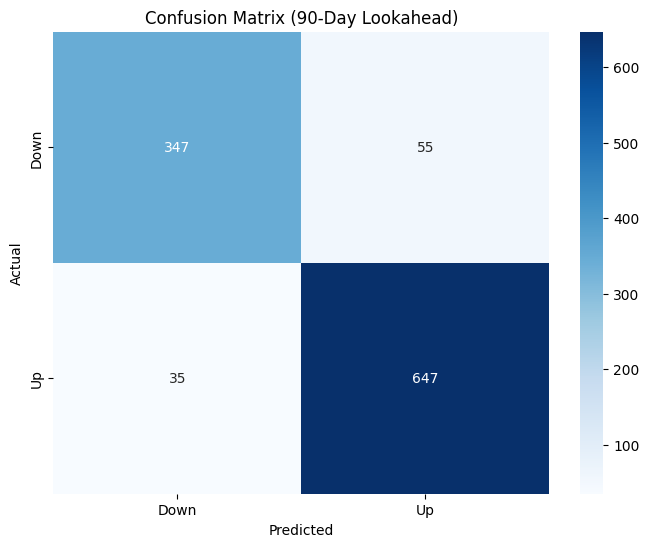

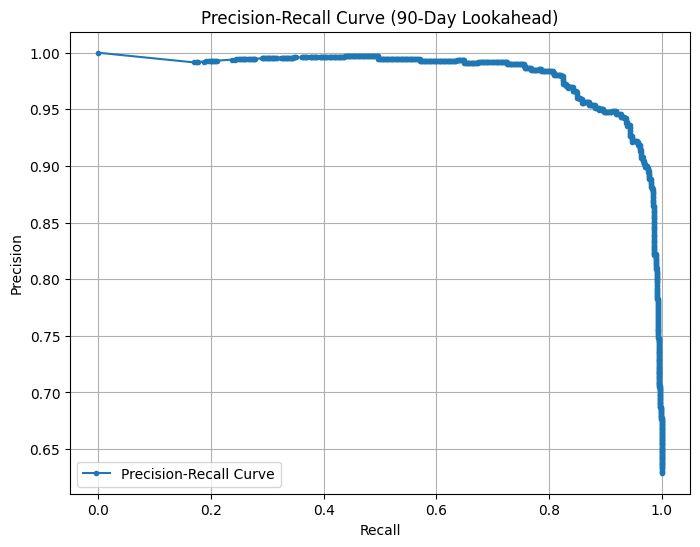

In [83]:
model_90, metrics_90 = train_and_evaluate(df, 90, feature_columns)
visualize_results(metrics_90, 90)


Results for 180-Day Lookahead
Accuracy: 0.9499
Precision: 0.9623
Recall: 0.9637
F1 Score: 0.9630
Confusion Matrix:
[[314  27]
 [ 26 690]]


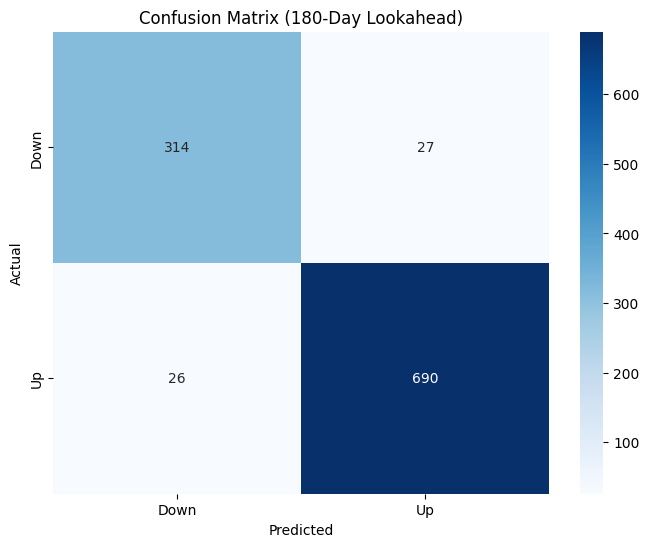

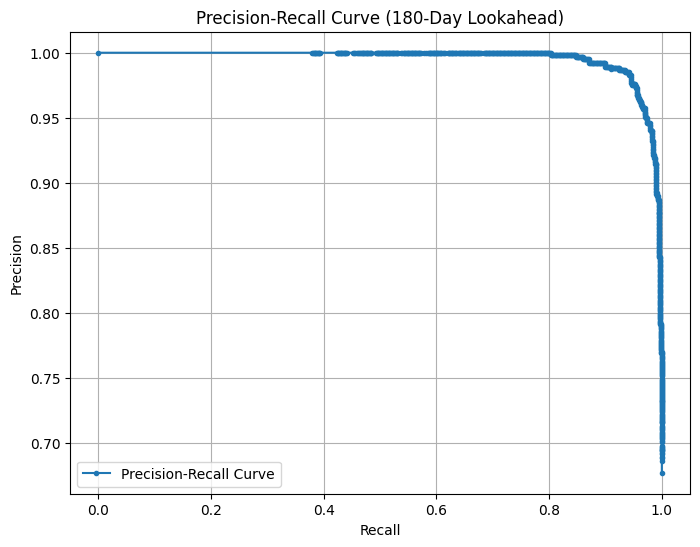

In [84]:
model_180, metrics_180 = train_and_evaluate(df, 180, feature_columns)
visualize_results(metrics_180, 180)


Results for 365-Day Lookahead
Accuracy: 0.9870
Precision: 0.9884
Recall: 0.9948
F1 Score: 0.9916
Confusion Matrix:
[[219   9]
 [  4 770]]


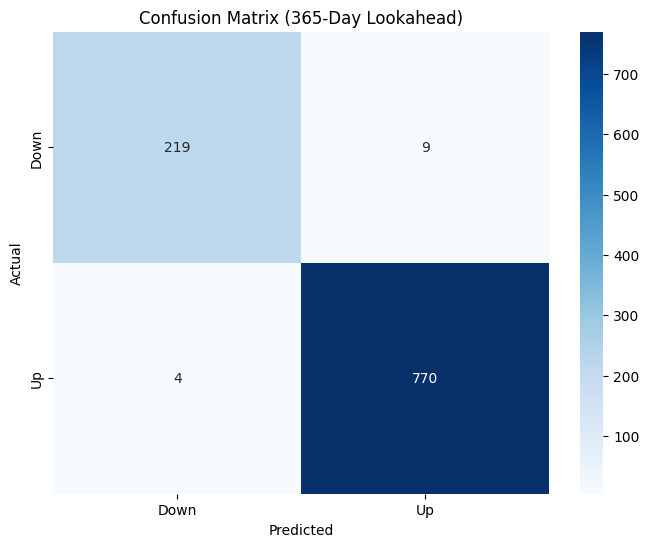

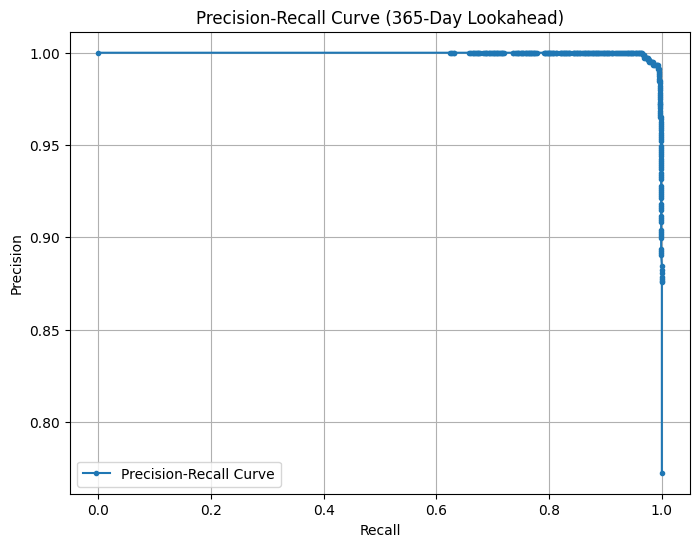

In [85]:
model_365, metrics_365 = train_and_evaluate(df, 365, feature_columns)
visualize_results(metrics_365, 365)

## Summary and Comparison of Lookahead Periods

The following table summarizes the performance metrics for the 14-day and 30-day lookahead periods. This comparison provides insights into how model performance changes with different prediction horizons.


   Lookahead Days  Accuracy  Precision    Recall  F1 Score
0               7  0.737601   0.728291  0.842788  0.781367
1              14  0.814815   0.813253  0.869565  0.840467
2              30  0.866606   0.860294  0.918367  0.888383
3              45  0.889800   0.884334  0.934985  0.908954
4              90  0.916974   0.921652  0.948680  0.934971
5             180  0.949858   0.962343  0.963687  0.963015
6             365  0.987026   0.988447  0.994832  0.991629


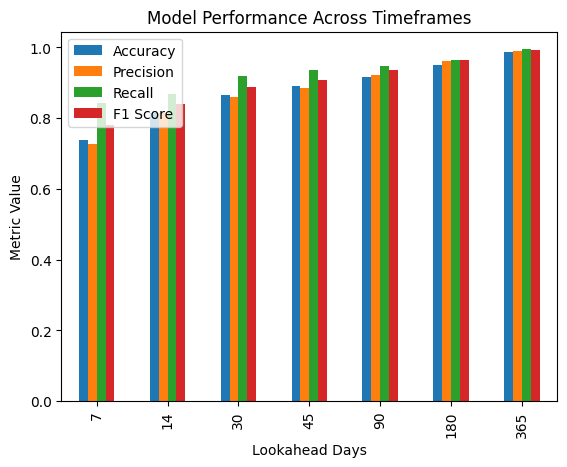

In [86]:
# Combine results for all lookahead periods: 7, 14, 30, 45, 90, 180, and 365 days
results = pd.DataFrame({
    'Lookahead Days': [7, 14, 30, 45, 90, 180, 365],
    'Accuracy': [metrics_7['accuracy'], metrics_14['accuracy'], metrics_30['accuracy'], metrics_45['accuracy'], metrics_90['accuracy'], metrics_180['accuracy'], metrics_365['accuracy']],
    'Precision': [metrics_7['precision'], metrics_14['precision'], metrics_30['precision'], metrics_45['precision'], metrics_90['precision'], metrics_180['precision'], metrics_365['precision']],
    'Recall': [metrics_7['recall'], metrics_14['recall'], metrics_30['recall'], metrics_45['recall'], metrics_90['recall'], metrics_180['recall'], metrics_365['recall']],
    'F1 Score': [metrics_7['f1_score'], metrics_14['f1_score'], metrics_30['f1_score'], metrics_45['f1_score'], metrics_90['f1_score'], metrics_180['f1_score'], metrics_365['f1_score']]
})

# Display results
print(results)

# Plot results
results.plot(x='Lookahead Days', y=['Accuracy', 'Precision', 'Recall', 'F1 Score'], kind='bar')
plt.title("Model Performance Across Timeframes")
plt.ylabel("Metric Value")
plt.xlabel("Lookahead Days")
plt.legend(loc="best")
plt.show()
